In [96]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import math
import random

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
"""
ROOT_PATH = "./"
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


## Create a Torch.Dataset class for the training dataset

In [3]:
def get_rotation_matrix(inputs, device=DEVICE): 
    vectors = inputs[:, 1, :]
    matrices = torch.zeros((vectors.shape[0], 2, 2)).to(device).float()
    for i in range(vectors.shape[0]):
        matrices[i] = rotate_matrix(vectors[i]).to(device)
    return matrices

def rotate_matrix(v, device=DEVICE):
    """
    Rotates the vector into the (1, 1) direction
    """    
    a, b = v
    norm = torch.linalg.norm(v)
    if norm == 0:
        Q1 = torch.eye(2).to(device)
    else:
        Q1 = torch.tensor([[a, b], [-b, a]]).to(device) / torch.linalg.norm(v)
    Q2 = torch.tensor([[1, -1], [1, 1]]).to(device) / torch.sqrt(torch.tensor(2).to(device))
    
    return Q2.float() @ Q1.float()

In [4]:
# def normalize(A, Q, T):
#     return torch.matmul((A - T.unsqueeze(1)), Q.T)

def revert(A, Q, T):
    return torch.matmul(A, Q) + T.unsqueeze(1)

In [5]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=False, normalize=False):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.normalize = normalize
        self.split = split
        self.inputs, self.outputs = self.get_city_trajectories(city=city, split=split)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == 'train':       
            data = (self.inputs[idx], self.outputs[idx])
            return data     
        return self.inputs[idx]
    
    def get_city_trajectories(self, city="palo-alto", split="train", device=DEVICE):
        assert city in cities and split in splits

        # get input
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = torch.tensor(inputs).to(device).float()

        # store input starting positions and rotation matrix
        self.T0 = inputs[:, 0, :]

        # normalize inputs
        if self.normalize:     
            # translation
            inputs = inputs - self.T0.unsqueeze(1)
            
            # rotation
            self.Q0 = get_rotation_matrix(inputs)
            inputs = torch.matmul(inputs, self.Q0.transpose(1, 2))

        # get outputs
        outputs = None
        if split == "train":
            # get outputs
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = torch.tensor(outputs).to(device).float()
            
            # normalize outputs
            if self.normalize:      
                # translation
                outputs = outputs - self.T0.unsqueeze(1)
                    
                # rotation
                outputs = torch.matmul(outputs, self.Q0.transpose(1, 2))
        return inputs, outputs

In [6]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' #'test' #'train'
train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalize=True)

len(train_dataset)

11993

## Create a DataLoader class for training

In [7]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz, drop_last=True)
len(train_loader)

2998

## Sample a batch of data and visualize 

In [8]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    inp = inp.cpu().detach().numpy()
    out = out.cpu().detach().numpy()
    batch_sz, agent_sz = inp.shape[0], inp.shape[1]
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.2, wspace=.5)
    axs = axs.ravel()   
    for i in range(4):
        axs[i].xaxis.set_ticks([inp[i,0,0],
                                   inp[i,-1,0], out[i,-1,0]])
        axs[i].yaxis.set_ticks([inp[i,0,1],
                                   inp[i,-1,1], out[i,-1,1]])

        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

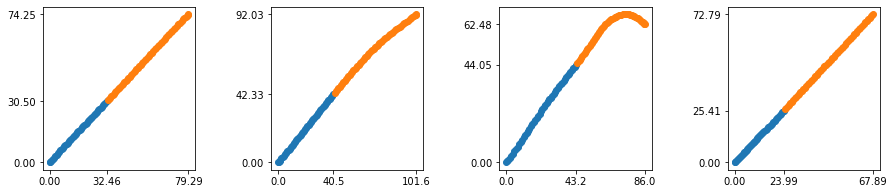

In [9]:
for i_batch, data in enumerate(train_loader):
    show_sample_batch(data)
    break

## Transformer

In [91]:
class TransformerTrajectory(nn.Module):
    def __init__(
        self,
        batch_size,
        model_dim, 
        n_heads=8, 
        linear_dim=256, 
        dropout_rate=0.1, 
        encoder_layers=1, 
        decoder_layers=1,
        input_dim=2,
        teacher_ratio=0.5
    ):
        super(TransformerTrajectory, self).__init__()
        self.batch_size = batch_size
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.linear_dim = linear_dim
        self.dropout_rate = dropout_rate
        self.encoder_layers = encoder_layers
        self.input_dim = input_dim
        self.input_length = 50
        self.output_length = 60
        
        # input linear embedding
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, model_dim),
            nn.LeakyReLU(),
            nn.Linear(model_dim, model_dim),
            nn.LeakyReLU(),
            nn.Linear(model_dim, model_dim)
        )
        
        
        # encoder
        encoder = nn.TransformerEncoderLayer(
            d_model=model_dim, 
            nhead=n_heads, 
            dim_feedforward=linear_dim, 
            dropout=dropout_rate, 
            batch_first=True,
            device=DEVICE
        )
        self.encoder = nn.TransformerEncoder(encoder, num_layers=encoder_layers, norm=None)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.input_length * model_dim, linear_dim),
            nn.LeakyReLU(), 
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, self.output_length * input_dim)
        )
    
    def get_angles(self, pos, i, D):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
        return pos * angle_rates

    def positional_encoding(self, D, position=110, dim=3, device=DEVICE):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                np.arange(D)[np.newaxis, :],
                                D)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        if dim == 3:
            pos_encoding = angle_rads[np.newaxis, ...]
        elif dim == 4:
            pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
        return torch.tensor(pos_encoding, device=device)
    
    def forward(self, inputs):
        input_pos = self.input_projection(inputs)
        input_pos += self.positional_encoding(self.model_dim)[:, :self.input_length, :]
        memory = self.encoder(input_pos).reshape(self.batch_size, -1)
        out = self.decoder(memory)
        return out.reshape(self.batch_size, self.output_length, -1)

## Train the Transformer

In [93]:
def train(
    batch_size, 
    city, 
    model_dim,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    num_iters,
    learning_rate,
    factor,
    patience,
    device=DEVICE,
    model=None
):    
    # Create the training/validation set
    train_dataset = ArgoverseDataset(city=city, split='train', transform=False, normalize=True)
    train_sz = int(len(train_dataset) * 0.9)
    val_sz = len(train_dataset) - train_sz
    train_data, val_data = torch.utils.data.random_split(train_dataset, [train_sz, val_sz])
    train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, drop_last=True)
    
    
    if model is None:
        # Initialize the model/optimizer/loss function
        model = TransformerTrajectory(
            batch_size=batch_size,
            model_dim=model_dim, 
            n_heads=n_heads, 
            linear_dim=linear_dim, 
            dropout_rate=dropout_rate, 
            encoder_layers=encoder_layers
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    loss_function = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True) 
    
    # Print out how many parameters to train
    param_sizes = [p.numel() for p in model.parameters()]
    print(f"number of weight/biases matrices: {len(param_sizes)} "
          f"for a total of {np.sum(param_sizes)} parameters ")
    
    avg_train_loss, avg_val_loss = [], []
    best_val_score = float('inf')
    
    # Start training
    for epoch in tqdm(list(range(num_iters))):
        print(f'Epoch {epoch+1}')
        print('Training & Validating ', end='')
        
        train_loss, val_loss = [], []
        
        # Training set
        for batches, (X, y) in enumerate(train_loader):
            X = X.to(device).float()
            y = y.to(device).float()
            
            # Track progress
            if (batches + 1) % 20 == 0:
                print('-', end='')
            
            # Forward pass
            optimizer.zero_grad()
            out = model(X)
            
            # Backpropagation
            loss = loss_function(out, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        print()
        avg_train = np.mean(train_loss)
        avg_train_loss.append(avg_train)
        

        # Evaluate on val set
        with torch.no_grad():
            for batches, (X, y) in enumerate(val_loader):
                X = X.to(device).float()
                y = y.to(device).float()
                
                out = model(X)
                loss = loss_function(out, y)
                val_loss.append(loss.item())
                
            avg_val = np.mean(val_loss)
            avg_val_loss.append(avg_val)

        print(f'- Training Loss: {avg_train}')
        print(f'- Validation Loss: {avg_val}')
        print()
        
        scheduler.step(avg_val)
        
        # save better model
        if avg_val < best_val_score:
            best_val_score = avg_val
            torch.save(model, f'baseline_{city}_0528.pt')
        
    return model, (avg_train_loss, avg_val_loss)

In [ ]:
def plot_loss(start_from, city, split, losses):

    avg_train_loss, avg_val_loss = losses
    plt.plot(np.sqrt(avg_train_loss[start_from:]), label='train_loss')
    plt.plot(np.sqrt(avg_val_loss[start_from:]), label='validation_loss')
    plt.title(f'{city} RMSE {split} Loss vs. Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
def vis_results(city, split, batch_size, model, idx, device=DEVICE):
    train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalize=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    
    with torch.no_grad():
        for X, y in train_loader:
            X = X.to(device).float()
            y = y.to(device).float()

            out = predict(model, X)
            break
    
    X = X.cpu()
    y = y.cpu()
    out = out.cpu()
    
    Q = train_dataset.Q0[idx].cpu()
    T = train_dataset.T0[idx].cpu()
    X = X[idx] @ Q + T
    y = y[idx] @ Q + T
    out = out[idx] @ Q + T
    
    plt.scatter(X[:, 0], X[:, 1], label='seed')
    plt.scatter(y[:, 0], y[:, 1], label='ground truth')
    plt.scatter(out[:, 0], out[:, 1], label='prediction')
    plt.title(f'Random Sample From {city}_{split} Projectile Visualization')
    plt.legend()
    plt.show()

In [133]:
def vis_test(city, split, batch_sz, model, idx, norm_viz=True):
    '''
    This is the last batch, which is usually not complete and need to fill with 0s.
    Check if I convert the prediction back correctly or not
    '''
    
    # Create the dataset for testing
    test_dataset = ArgoverseDataset(city = city, split = split,
                                    transform=False, normalized=True)
        
    test_loader = DataLoader(test_dataset, batch_size=batch_sz)
    
    with torch.no_grad():
        for X in test_loader:
            if len(X) == batch_sz:
                continue
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0)).float()
            X = X.to(device).float()
            S = X.shape[1]
            mask = create_look_ahead_mask(S)

            output = model(X, mask)[0].reshape(batch_size, -1, 2)

            X = X.cpu()
            output = output.cpu()

            if norm_viz:
                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
            else:
                rotation =  test_dataset.rotate_matrix[-1].T
                X[idx] = X[idx] @ np.linalg.inv(rotation)
                X[idx] = X[idx] + test_dataset.start_pos[-1, : ]
                output[idx] = output[idx] @ np.linalg.inv(rotation)
                output[idx] = output[idx] + test_dataset.start_pos[-1, : ]

                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
    

In [142]:
def make_pred(test_loader, batch_sz, model):
    '''
    Remember to use test_dataset stats, NOT train_dataset
    '''
    count_row = 0
    out = []

    for X in test_loader:
        if len(X) != batch_sz:
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0))
            
#             a = test_dataset.rotate_matrix[-1].T
#             temp = X[20]@np.linalg.inv(a) + test_dataset.start_pos[-1]
#             plt.scatter(temp[:, 0], temp[:, 1], label='input')

        X = X.to(device).float()
    
        S = X.shape[1]
        mask = create_look_ahead_mask(S)

        pred = model(X, mask)[0].reshape(batch_size, -1, 2).cpu().detach().numpy()

        for i in range(batch_sz):
            if count_row >= len(test_dataset):
                break
                
#             if count_row == (len(test_dataset) - 1):
#                 plt.scatter(X[i, :, 0], X[i, :, 1], label='input')
#                 plt.scatter(pred[i, :, 0], pred[i, :, 1], label='pred')
#                 plt.legend()
#                 plt.show()

            rotation =  test_dataset.rotate_matrix[count_row].T
            pred[i] = pred[i] @ np.linalg.inv(rotation)
            pred[i] = pred[i] + test_dataset.start_pos[count_row, : ]

    #         print(pred[i, 0, :])
                
            out.append(pred[i])
            count_row += 1 
            
    #         print(count_row)
    #         print(pred[0, :5, :])

    out = np.array(out).reshape(len(test_dataset), -1)

    return out

In [65]:
def predict(model, inputs):
    with torch.no_grad():
        total_steps = 60 // model.output_length

        # predict first roll
        step_pred = model(inputs)
        inputs = torch.cat((
            inputs,
            step_pred
        ), dim=1)

        for step in range(1, total_steps):
            # take chunk
            cur_inputs = inputs[:, step * model.output_length:, :].clone()

            # normalize
            T_t = cur_inputs[:, 0, :].clone()
            cur_inputs = cur_inputs - T_t.unsqueeze(1)

            Q_t = get_rotation_matrix(cur_inputs)
            cur_inputs = torch.matmul(cur_inputs, Q_t.transpose(1, 2))

            # autoregress
            step_pred = model(cur_inputs)

            # revert to original scale
            step_pred = torch.matmul(step_pred, Q_t) + T_t.unsqueeze(1)
            
            # add new predictions
            inputs = torch.cat((
                inputs,
                step_pred
            ), dim=1)

        return inputs[:, model.input_length:, :]

### palo-alto

In [77]:
# Hyperparameter
batch_size = 32
city = 'palo-alto'
model_dim = 32
n_heads = 8
linear_dim = 64 # [32, 128]
dropout_rate = 0 # [0, 0.5]
encoder_layers = 4
num_iters = 120 # [50, 100]
learning_rate = 0.002 # [0.001, 0.005]
factor = 0.5 # 0.1 ~ 0.99
patience = 3

palo_net, palo_loss, palo_val_loader = train(
    batch_size, 
    city, 
    model_dim,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    num_iters,
    learning_rate,
    factor,
    patience,
    device=DEVICE
)

number of weight/biases matrices: 56 for a total of 142846 parameters 


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1
Training & Validating ----------------
- Training Loss: 63.51032709721642
- Validation Loss: 135.76797578141495

Epoch 2
Training & Validating ----------------
- Training Loss: 4.780918461632658
- Validation Loss: 53.66299314756651

Epoch 3
Training & Validating ----------------
- Training Loss: 3.2088682520637173
- Validation Loss: 51.39661536345611

Epoch 4
Training & Validating ----------------
- Training Loss: 2.838256866181993
- Validation Loss: 48.971805520959805

Epoch 5
Training & Validating ----------------
- Training Loss: 2.385825780980311
- Validation Loss: 61.56132486704234

Epoch 6
Training & Validating ----------------
- Training Loss: 2.8390462789408177
- Validation Loss: 48.648963876672696

Epoch 7
Training & Validating ----------------
- Training Loss: 2.102795801106122
- Validation Loss: 52.75965350383037

Epoch 8
Training & Validating ----------------
- Training Loss: 3.2314580673633766
- Validation Loss: 42.19729237943082

Epoch 9
Training & Validating ----

Training & Validating ----------------
- Training Loss: 0.3492702539755966
- Validation Loss: 26.368978113741488

Epoch 67
Training & Validating ----------------
- Training Loss: 0.34863646695451145
- Validation Loss: 26.359764434195853

Epoch 68
Training & Validating ----------------
- Training Loss: 0.34789807588215754
- Validation Loss: 26.332634384567672

Epoch 69
Training & Validating ----------------
- Training Loss: 0.3471685161134256
- Validation Loss: 26.303015244973672

Epoch 70
Training & Validating ----------------
- Training Loss: 0.3465193271283226
- Validation Loss: 26.2953540698902

Epoch 71
Training & Validating ----------------
- Training Loss: 0.34589605088669045
- Validation Loss: 26.268938837824642

Epoch 72
Training & Validating ----------------
- Training Loss: 0.3452887502153479
- Validation Loss: 26.253975919775062

Epoch 73
Training & Validating ----------------
- Training Loss: 0.3446948850411336
- Validation Loss: 26.22440497939651

Epoch 74
Training & Valid

In [19]:
# # Hyperparameter
# batch_size = 32 
# city = 'palo-alto'
# split = 'train'
# num_layers = 4 # The more of this, more easily to overfit
# D = 8 # DIMENSION                                             8
# H = 8 # NUMBER OF HEADS                                       8 
# hidden_mlp_dim = 25 # [32, 128]                               32
# inp_features = 2 
# out_features = 120                                         
# dropout_rate = 0 # [0, 0.5]
# n_epochs = 50 # [50, 100]
# learning_rate = 0.002 # [0.001, 0.01] 0.002
# factor = 0.6 # 0.1 ~ 0.99

# palo_net, palo_losses = train(batch_size, city, split, num_layers, D, H, hidden_mlp_dim, 
#           inp_features, out_features, dropout_rate, n_epochs, learning_rate, factor)

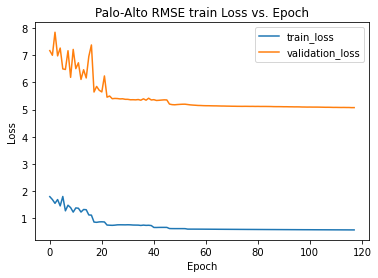

In [78]:
plot_loss(2, 'Palo-Alto', 'train', palo_loss)

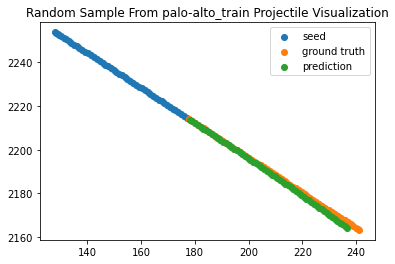

In [80]:
vis_results('palo-alto', 'train', 32, palo_net, 28)

In [ ]:
# Evaluate on val set
with torch.no_grad():
    for batches, (X, y) in enumerate(val_loader):
        X = X.to(device).float()
        y = y.to(device).float()

        out = model(X)
        loss = loss_function(out, y[:, :10, :].reshape(batch_size, -1))
        val_loss.append(loss.item())

    avg_val = np.mean(val_loss)
    avg_val_loss.append(avg_val)

22


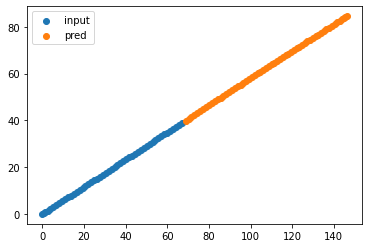

In [138]:
# intialize a dataset
city = 'palo-alto' 
split = 'test' 
batch_sz = 32

vis_test(city, split, batch_sz, palo_net, 21, True)

In [139]:
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)   
print(len(temp_dataset)) 
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
# test_dataset.start_pos
len(temp_loader)

1686


53

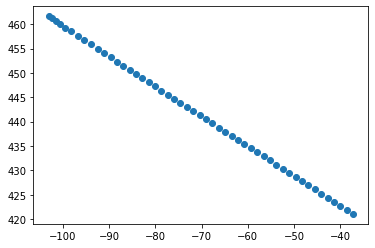

In [140]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[21, :, 0], X[21, :, 1], label='input')
    plt.legend
    plt.show()

22


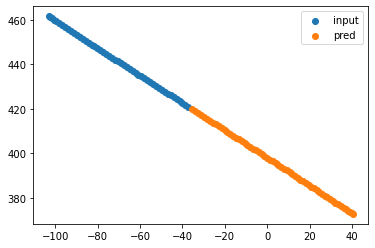

In [141]:
vis_test(city, split, batch_sz, palo_net, 21, False)

In [143]:
city = 'palo-alto' 
split = 'test'
test_dataset = ArgoverseDataset(city = city, split = split,
                                    transform=False, normalized=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
batch_sz = 32

palo_array = make_pred(test_loader, batch_sz, palo_net)
palo_array.shape

22


(1686, 120)

In [144]:
palo_array[-1, -2:]

array([ 40.385475, 372.85968 ], dtype=float32)

### austin
- best KAGGLE val loss: 21.4315324826027

In [186]:
# Hyperparameter
batch_size = 32 
city = 'austin'
split = 'train'
num_layers = 4 # The more of this, more easily to overfit
D = 8 # DIMENSION                                             8
H = 8 # NUMBER OF HEADS                                       8 
hidden_mlp_dim = 25 # [32, 128]                               32
inp_features = 2 
out_features = 120                                         
dropout_rate = 0 # [0, 0.5]
n_epochs = 50 # [50, 100]
learning_rate = 0.002 # [0.001, 0.01] 0.002
factor = 0.5 # 0.1 ~ 0.99

austin_net, austin_losses = train(batch_size, city, split, num_layers, D, H, hidden_mlp_dim, 
          inp_features, out_features, dropout_rate, n_epochs, learning_rate, factor)

(43041, 50, 2)
(43041, 60, 2)
number of weight/biases matrices: 68 for a total of 58996 parameters 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
Training & Validating ------------------------------------------------------------
- Training Loss: 160.2444830918115
- Validation Loss: 51.26222463863999
- Train Time: 18.553128242492676
- Elapsed Time: 18.98277187347412

Epoch 2
Training & Validating ------------------------------------------------------------
- Training Loss: 44.33916311894566
- Validation Loss: 35.705901501783686
- Train Time: 37.18886470794678
- Elapsed Time: 38.05703091621399

Epoch 3
Training & Validating ------------------------------------------------------------
- Training Loss: 36.53762260389722
- Validation Loss: 30.305790146784997
- Train Time: 58.0343804359436
- Elapsed Time: 59.34428787231445

Epoch 4
Training & Validating ------------------------------------------------------------
- Training Loss: 32.07497746333603
- Validation Loss: 30.878903623837143
- Train Time: 76.67767596244812
- Elapsed Time: 78.42059850692749

Epoch 5
Training & Validating -----------------------------------------------

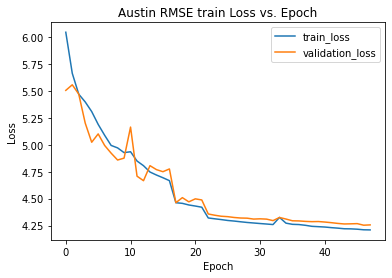

In [187]:
plot_loss(2, 'Austin', 'train', austin_losses)

(43041, 50, 2)
(43041, 60, 2)
torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


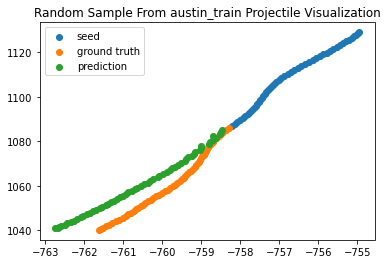

In [192]:
vis_results('austin', 'train', 32, austin_net, 29)

21


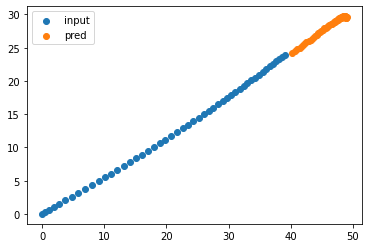

In [207]:
# intialize a dataset
city = 'austin' 
split = 'test' 
batch_sz = 32

vis_test(city, split, batch_sz, austin_net, 20, True)

6325


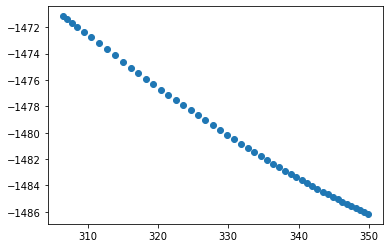

In [202]:
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)   
print(len(temp_dataset)) 
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
# test_dataset.start_pos
len(temp_loader)

for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[20, :, 0], X[20, :, 1], label='input')
    plt.legend
    plt.show()

21


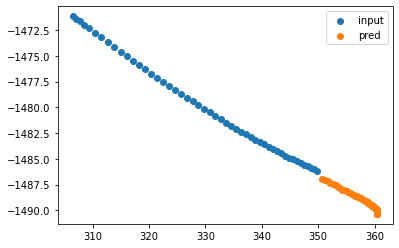

In [210]:
vis_test(city, split, batch_sz, austin_net, 20, False)

In [211]:
city = 'austin' 
split = 'test'
test_dataset = ArgoverseDataset(city = city, split = split,
                                    transform=False, normalized=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
batch_sz = 32

austin_array = make_pred(test_loader, batch_sz, austin_net)
austin_array.shape

21


(6325, 120)

In [212]:
austin_array[-1, -2:]

array([  360.39395, -1490.3457 ], dtype=float32)

### miami
- best KAGGLE val loss: 18.53021953259295
- parameters to tune: 
1. num_layers --
2. D, H --
3. ...

In [214]:
# Hyperparameter
batch_size = 32 
city = 'miami'
split = 'train'
num_layers = 4 # The more of this, more easily to overfit
D = 8 # DIMENSION                                             8
H = 8 # NUMBER OF HEADS                                       8 
hidden_mlp_dim = 25 # [32, 128]                               32
inp_features = 2 
out_features = 120                                         
dropout_rate = 0 # [0, 0.5]
n_epochs = 50 # [50, 100]
learning_rate = 0.002 # [0.001, 0.005]
factor = 0.5 # 0.1 ~ 0.99

miami_net, miami_losses = train(batch_size, city, split, num_layers, D, H, hidden_mlp_dim, 
          inp_features, out_features, dropout_rate, n_epochs, learning_rate, factor)

(55029, 50, 2)
(55029, 60, 2)
number of weight/biases matrices: 68 for a total of 58996 parameters 


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 100.69477040981891
- Validation Loss: 32.23611554486013
- Train Time: 27.138952255249023
- Elapsed Time: 27.769274473190308

Epoch 2
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 30.799949250224333
- Validation Loss: 29.10705078415006
- Train Time: 52.593130111694336
- Elapsed Time: 53.928325176239014

Epoch 3
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 26.288511755856376
- Validation Loss: 22.78040269383213
- Train Time: 80.16711354255676
- Elapsed Time: 82.09034371376038

Epoch 4
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 24.165957853419595
- Validation Loss: 21.099017363542703
- Train Time: 106.46147775650024
- Elapsed Time: 108.96677732467651

E

### Pittsburgh

In [95]:
# Hyperparameter
batch_size = 32
city = 'pittsburgh'
model_dim = 16
n_heads = 8
linear_dim = 64 # [32, 128]
dropout_rate = 0 # [0, 0.5]
encoder_layers = 2
num_iters = 120 # [50, 100]
learning_rate = 0.002 # [0.001, 0.005]
factor = 0.5 # 0.1 ~ 0.99
patience = 2

pitts_net, pitts_loss = train(
    batch_size, 
    city, 
    model_dim,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    num_iters,
    learning_rate,
    factor,
    patience,
    device=DEVICE
)

number of weight/biases matrices: 40 for a total of 78696 parameters 


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1
Training & Validating -------------------------------------------------------------
- Training Loss: 151.26897548226748
- Validation Loss: 119.16168740216423

Epoch 2
Training & Validating -------------------------------------------------------------
- Training Loss: 80.20964629665698
- Validation Loss: 34.1089406153735

Epoch 3
Training & Validating -------------------------------------------------------------
- Training Loss: 34.46098524215174
- Validation Loss: 34.244859751533056

Epoch 4
Training & Validating -------------------------------------------------------------
- Training Loss: 32.388562252318934
- Validation Loss: 31.218628013835232

Epoch 5
Training & Validating -------------------------------------------------------------
- Training Loss: 28.713614398357915
- Validation Loss: 29.294742745511673

Epoch 6
Training & Validating -------------------------------------------------------------
- Training Loss: 27.402598511938955
- Validation Loss: 26.373353130677167

Ep

Training & Validating -------------------------------------------------------------
- Training Loss: 16.303474661181955
- Validation Loss: 16.609053727458505

Epoch 49
Training & Validating -------------------------------------------------------------
- Training Loss: 16.297906315015034
- Validation Loss: 16.677277877050287

Epoch 50
Training & Validating -------------------------------------------------------------
- Training Loss: 16.29357951412014
- Validation Loss: 16.66928186486749

Epoch    50: reducing learning rate of group 0 to 1.5625e-05.
Epoch 51
Training & Validating -------------------------------------------------------------
- Training Loss: 16.241493633759568
- Validation Loss: 16.535032405572778

Epoch 52
Training & Validating -------------------------------------------------------------
- Training Loss: 16.21921888675565
- Validation Loss: 16.49189076353522

Epoch 53
Training & Validating -------------------------------------------------------------
- Training Loss: 1

Training & Validating -------------------------------------------------------------
- Training Loss: 16.133564243519228
- Validation Loss: 16.495356303804062

Epoch 94
Training & Validating -------------------------------------------------------------
- Training Loss: 16.13420334127214
- Validation Loss: 16.49529614869286

Epoch 95
Training & Validating -------------------------------------------------------------
- Training Loss: 16.134822671319924
- Validation Loss: 16.495303995469037

Epoch 96
Training & Validating -------------------------------------------------------------
- Training Loss: 16.1297259696948
- Validation Loss: 16.495274743613074

Epoch 97
Training & Validating -------------------------------------------------------------
- Training Loss: 16.135273336390263
- Validation Loss: 16.49530271922841

Epoch 98
Training & Validating -------------------------------------------------------------
- Training Loss: 16.13029425712972
- Validation Loss: 16.495345028007733

Epoch 9

In [44]:
# vis_results('pittsburgh', 'train', 32, pitts_net, 2)